# Predicting Build Failures from Composer Dependencies

This describes a very simple application of a tree-based method to learn which Composer dependencies contribute to build failures. It uses an out-of-the-box classifier from the Scikit Learn library for doing machine learning in Python.

First, some set-up...

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

## Totally unrealistic example for illustrative purposes

In this example we'll simulate data where there is a direct correlation between one particular dependency and failure, i.e. if that dependency is present, the build will certainly fail, otherwise it will succeed 99% of the time. We are going to learn from 10000 simulated builds where there are 12 dependencies each of which is either present or not present in each build. In a real life scenario our list of dependencies would be much longer than this - it would include every dependency seen in more than n builds (where n is some sensibly chosen number.) Also, different versions would have to be treated as different dependencies. With this long list of dependencies, which we are using as "features", "predictors" or "independent variables" in ML parlance, we would likely need a lot more than 10000 builds to learn from. But you get the idea ;)

In [2]:
n = 10000 # Number of "builds" to simulate
# List of dependencies
deps = [
  "symfony__assetic_bundle",
  "symfony__monolog_bundle",
  "symfony__swiftmailer_bundle",
  "symfony__symfony",
  "doctrine__common",
  "doctrine__doctrine_bundle",
  "doctrine__doctrine_fixtures_bundle",
  "doctrine__orm",
  "exercise__elastica_bundle",
  "friendsofsymfony__rest_bundle",
  "friendsofsymfony__user_bundle",
  "fzaninotto__faker"
]
m = len(deps) # number of features

Here we create an n x m matrix - each row is a build and each column is a dependency. We'll randomly assign the value 1 to 40% of the elements, indicating that a dependency is present for a particular build - all other elements will have a 0 value. This matrix is our set of predictors and we store it in the variable X.

Our y variable is our "outcome", in this case either success or failure which we denote with 1 and 0 respectively.

(The use of uppercase X variable and lowercase y outcome variable is typical in ML because X is usually a matrix and y is usually a column vector or array.)

In [3]:
X = np.random.binomial(1, 0.4, size=(n,m))
# Without our problematic dependencies, let's say builds will
# succeed 99% of the time
y = np.random.binomial(1, 0.99, size=(n,))
# Now add in our faulty dependency - we set the success to 0
# wherever the 3rd dependency is present
bool_arr = X[:,2]==1
y[bool_arr,] = 0
# To avoid overfitting, we want to train on only a portion of our data
# and hold out the remainder to evaluate our model with - the held out
# data is referred to as the "test set", as opposed to the "training
# set".
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Here we fit an "Extra Trees" model. This is short for "Extremely randomized trees" and is a variation on the more commonly used "Random Forest" algorithm. Both are based on the "decision tree" idea of asking questions of your data such that the answers take you along the path that leads to the correct classification for each observation.

After fitting the model we use it to make predictions for the success or failure of the builds we held out in our test data. We then check the accuracy of these predictions against the "true" outcomes.

In [4]:
# Fit an Extra Trees model to the data
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
# Get the predictions our model gives for the test set
y_pred = model.predict(X_test)
# See what proportion of predicted values is correct.
acc = sum(y_pred == y_test) / float(y_test.shape[0])
print("Prediction accuracy on unseen data: %.3f%%") % (acc*100)

Prediction accuracy on unseen data: 99.200%


With the Extra Trees classifier we can find out which features (dependencies) it deemed most important in determining the outcome. Here we plot the relative importance of the predictors. It has correctly identified the single dependency that always results in failure.

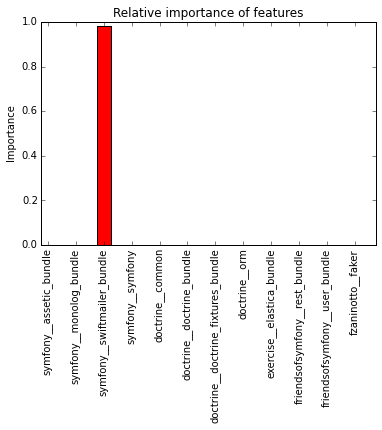

In [5]:
fig, ax = plt.subplots()
ind = np.arange(m)
width = 0.5
rects = ax.bar(ind, model.feature_importances_, width, color='r')
ax.set_ylabel('Importance')
ax.set_title('Relative importance of features')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(deps, rotation=90)
plt.show()

## Slightly more realistic example

Now imagine a scenario where a particular dependency, when installed with either of two other dependencies, will cause a failure 70% of the time. Here we're assuming that there's some other factor involved that results in the failures happening only 70% of the time and not 100% - for example, maybe certain types of test, which are present in 70% of builds, result in a failure. But we don't have access to that information, only the list of dependencies. Let's see what we can learn.

In [6]:
# Reset our outcome back to success 99% of the time
y = np.random.binomial(1, 0.99, size=(n,))
# Now our faulty dependencies are a bit more complex - we set the success to 0
# whenever the 3rd dependency is present AND either the 7th or the 9th is present.
boolean_indices = np.logical_and(X[:,2]==1, np.logical_or(X[:,6]==1, X[:,8]))
# But actually we want this to only result in a failure 70% of the time.
boolean_indices = np.logical_and(boolean_indices, np.random.binomial(1,0.7, size=(n,)))
y[boolean_indices,] = 0
# Again, split our data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [7]:
# Fit an Extra Trees model
model = ExtraTreesClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = sum(y_pred == y_test) / float(y_test.shape[0])
print("Prediction accuracy on unseen data: %.3f%%") % (acc*100)

Prediction accuracy on unseen data: 89.400%


Understandably, our prediction accuracy has gone down - the information that explains the 70/30 success/failure ratio in affected builds is simply not present in the data. However, the model can still show us which dependencies are important...

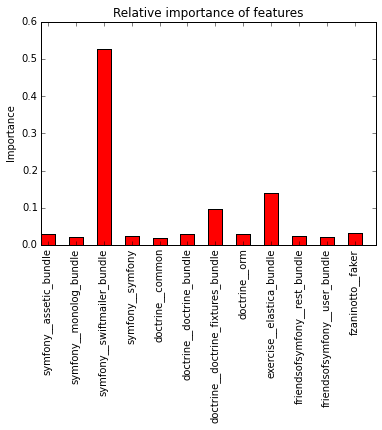

In [8]:
fig, ax = plt.subplots()
ind = np.arange(m)
width = 0.5
rects = ax.bar(ind, model.feature_importances_, width, color='r')
ax.set_ylabel('Importance')
ax.set_title('Relative importance of features')
ax.set_xticks(ind + width/2)
ax.set_xticklabels(deps, rotation=90)
plt.show()

This has been a very simple introduction to how ML techniques can be applied to real problems. It skipped past a lot of important stuff - such as dealing with the "class imbalance" problem that results from the fact that we have way more positive examples (build successes) than negative ones.

But hopefully it gives you a taste of how this stuff works! :D